In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import torch.distributions as dist
torch.manual_seed(2)
np.random.seed(2)

### Question 1


In [74]:
#Estimate for the normalizing constant of the Gaussian distribution
def estimate(N, a):
    uniform_distribution = dist.uniform.Uniform(-a, a)
    samples = uniform_distribution.sample((N,))
    func = lambda x: 2 * a * torch.exp(-(x**2) / 2)
    func_samples = func(samples)
    return func_samples.mean()

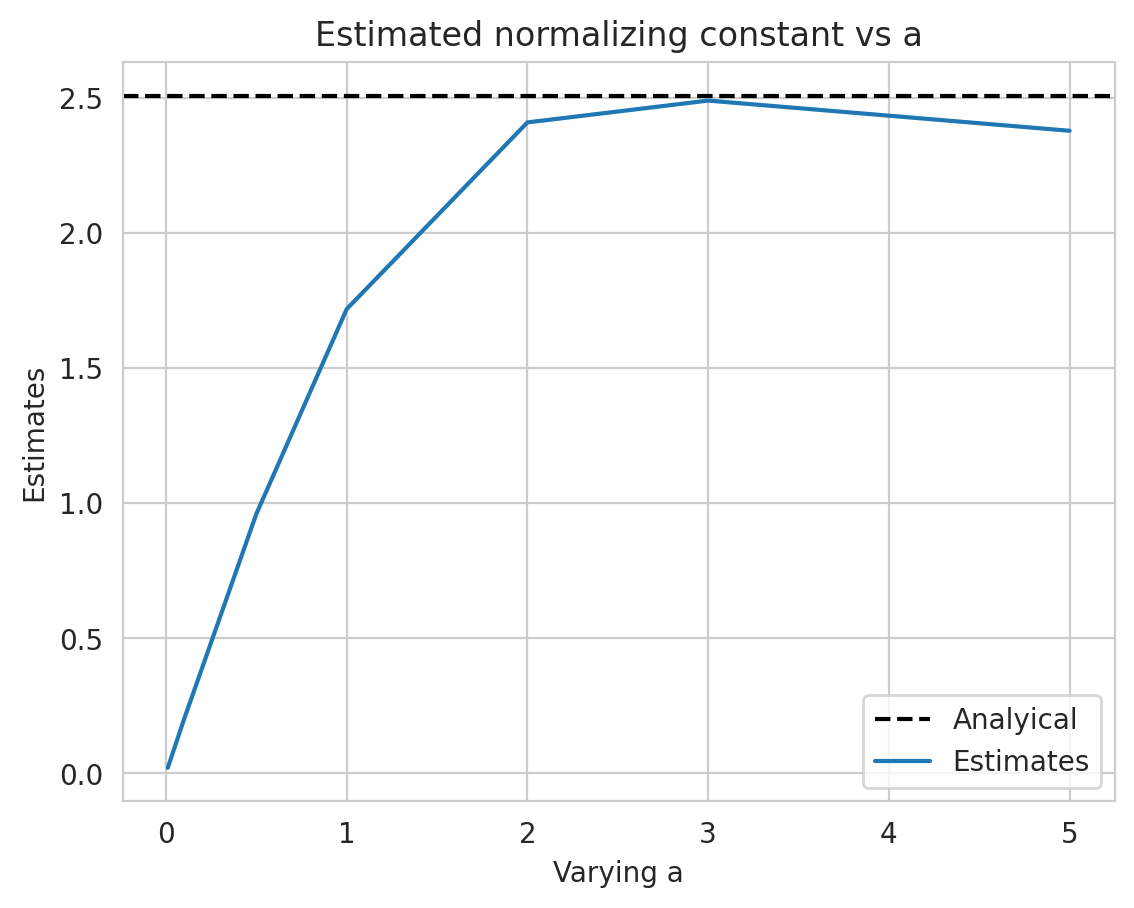

In [75]:
#different values of a
values_a = [0.01, 0.02, 0.05, 0.1, 0.5, 1, 2, 3, 5]
estimates = []
for i in values_a:
    #estimating for different values of a
    estimates.append(estimate(1000, i))
#plotting the estimates
plt.axhline(y=np.sqrt(2 * np.pi), color="k", linestyle="--", label="Analyical")
plt.xlabel("Varying a")
plt.ylabel("Estimates")
plt.title("Estimated normalizing constant vs a")
plt.plot(values_a, estimates, label="Estimates")
plt.legend()
plt.show()

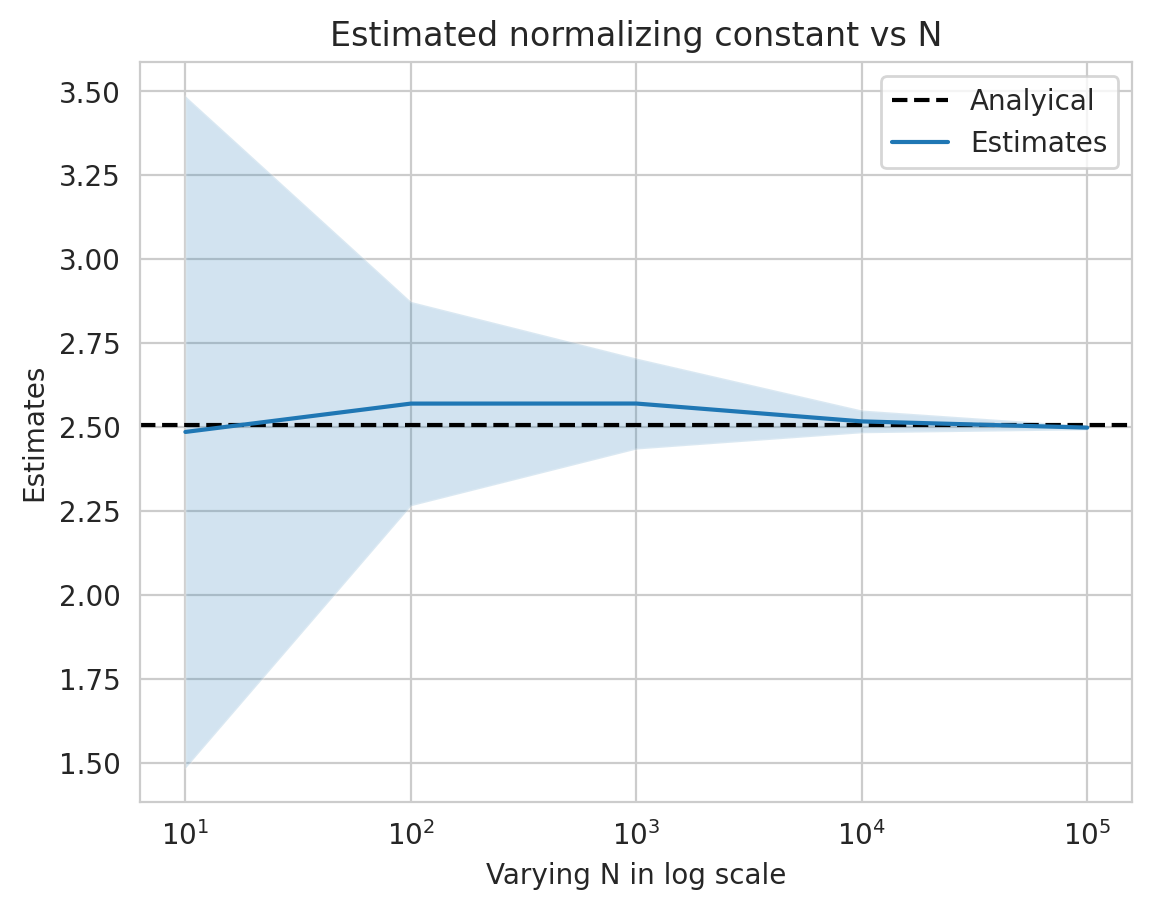

In [76]:
#different values of N
number_of_samples = [10, 100, 1000, 10000, 100000]
estimates = []
standard_deviation = []
# estimating for different values of N
for i in number_of_samples:
    temp = []
    for j in range(10):
        temp.append(estimate(i, 4))
    estimates.append(np.array(temp).mean())
    standard_deviation.append(np.array(temp).std())
#plotting the estimates
plt.axhline(y=np.sqrt(2 * np.pi), color="k", linestyle="--", label="Analyical")
plt.xlabel("Varying N in log scale")
plt.ylabel("Estimates")
plt.title("Estimated normalizing constant vs N")
plt.plot(number_of_samples, estimates, label="Estimates")
plt.xscale("log")
plt.fill_between(
    number_of_samples,
    np.array(estimates) - np.array(standard_deviation),
    np.array(estimates) + np.array(standard_deviation),
    alpha=0.2,
)
plt.legend()
plt.show()

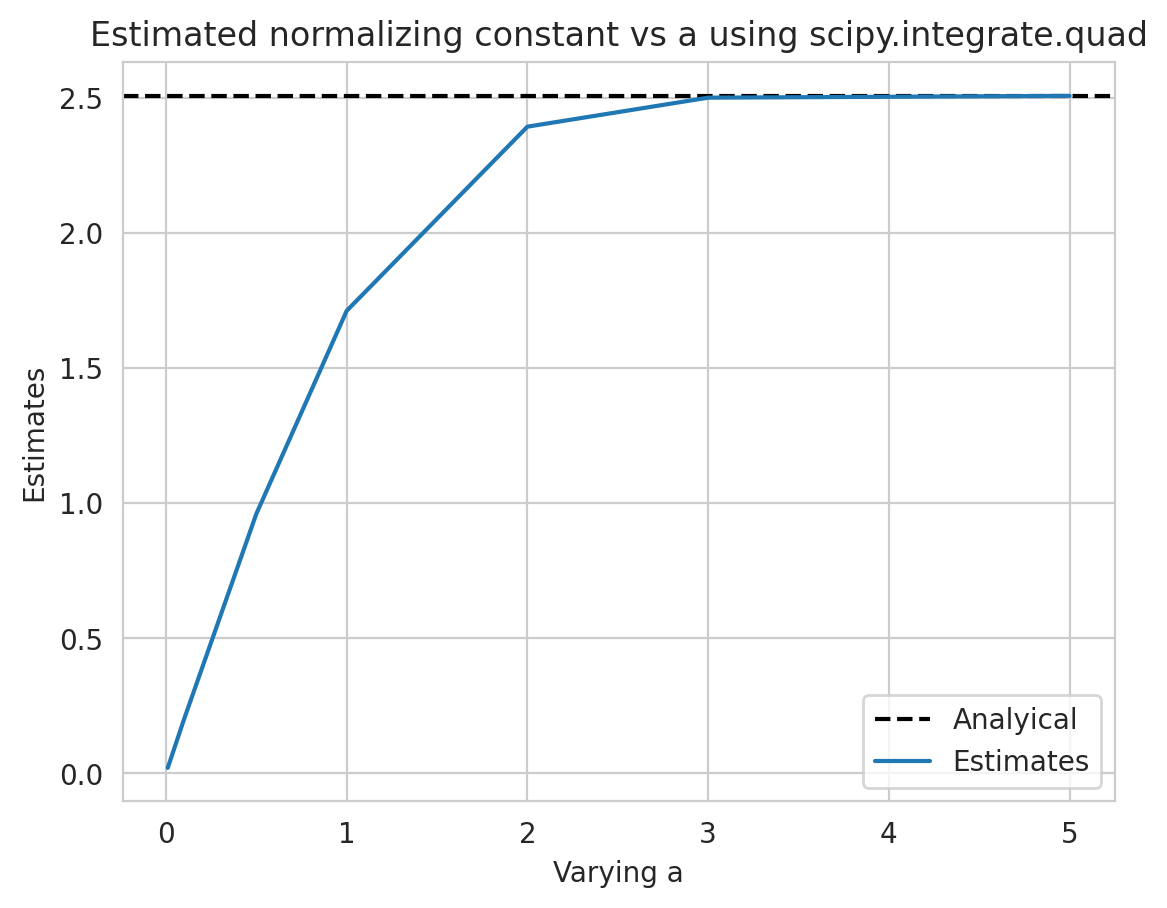

In [77]:
from scipy import integrate
def integral_value(a):
    func = lambda x: np.exp(-(x**2) / 2)
    return integrate.quad(func, -a, a)[0]
values_a = [0.01, 0.02, 0.05, 0.1, 0.5, 1, 2, 3, 5]
estimates = []
for i in values_a:
    estimates.append(integral_value(i))
plt.axhline(y=np.sqrt(2 * np.pi), color="k", linestyle="--", label="Analyical")
plt.xlabel("Varying a")
plt.ylabel("Estimates")
plt.title("Estimated normalizing constant vs a using scipy.integrate.quad")
plt.plot(values_a, estimates, label="Estimates")
plt.legend()
plt.show()

In [78]:
torch.manual_seed(2)

### Question 2

#### Derivation of ICDF from CDF
$$
\begin{aligned}
& y=\frac{1}{\pi} \tan ^{-1}\left(\frac{x-x_0}{\gamma}\right)+\frac{1}{2} \\
& \pi y=\tan ^{-1}\left(\frac{x-x_0}{\gamma}\right)+\frac{\pi}{2} \\
& \left(\pi y-\frac{\pi}{2}\right)=\tan ^{-1}\left(\frac{x-x_0}{\gamma}\right) \\
& \tan \left(\pi\left(y-\frac{1}{2}\right)\right)=\frac{x-x_0}{\gamma} \\
& \gamma \tan \left(\pi\left(y-\frac{1}{2}\right)\right)=x-x_0 \\
& I C D F \Rightarrow y=x_0+\gamma \tan \left(\pi\left(x-\frac{1}{2}\right)\right)
\end{aligned}
$$

In [79]:
def icdf_cauchy(x, gamma=1, x0=0):
    return x0 + gamma * torch.tan(torch.pi * (x - 0.5))


distri_uniform = dist.Uniform(0.05, 0.95)
samples = distri_uniform.sample((1000,))

cauchy_samples = icdf_cauchy(samples)
distri_cauchy = dist.Cauchy(loc=0, scale=1)
x = torch.linspace(-10, 10, 1000)
torch_samples = distri_cauchy.log_prob(x).exp()
torch_icdf = distri_cauchy.icdf(samples)

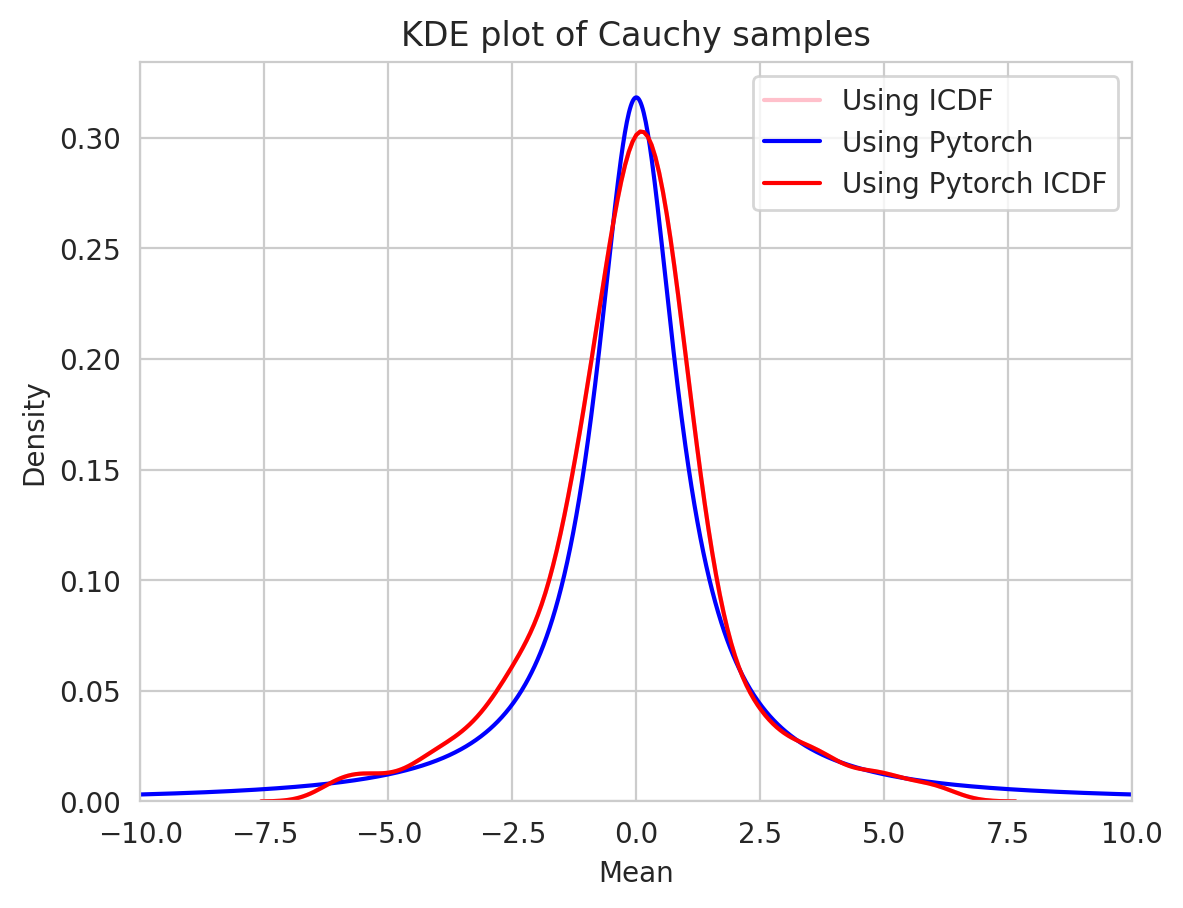

In [80]:
sns.kdeplot(cauchy_samples.numpy(), label="Using ICDF", color="pink")
plt.plot(x, torch_samples.numpy(), label="Using Pytorch", color="blue")
sns.kdeplot(torch_icdf.numpy(), label="Using Pytorch ICDF", color="red")
plt.xlabel("Mean")
plt.ylabel("Density")
plt.xlim(-10, 10)
plt.title("KDE plot of Cauchy samples")
plt.legend()
plt.show()

### Question 3

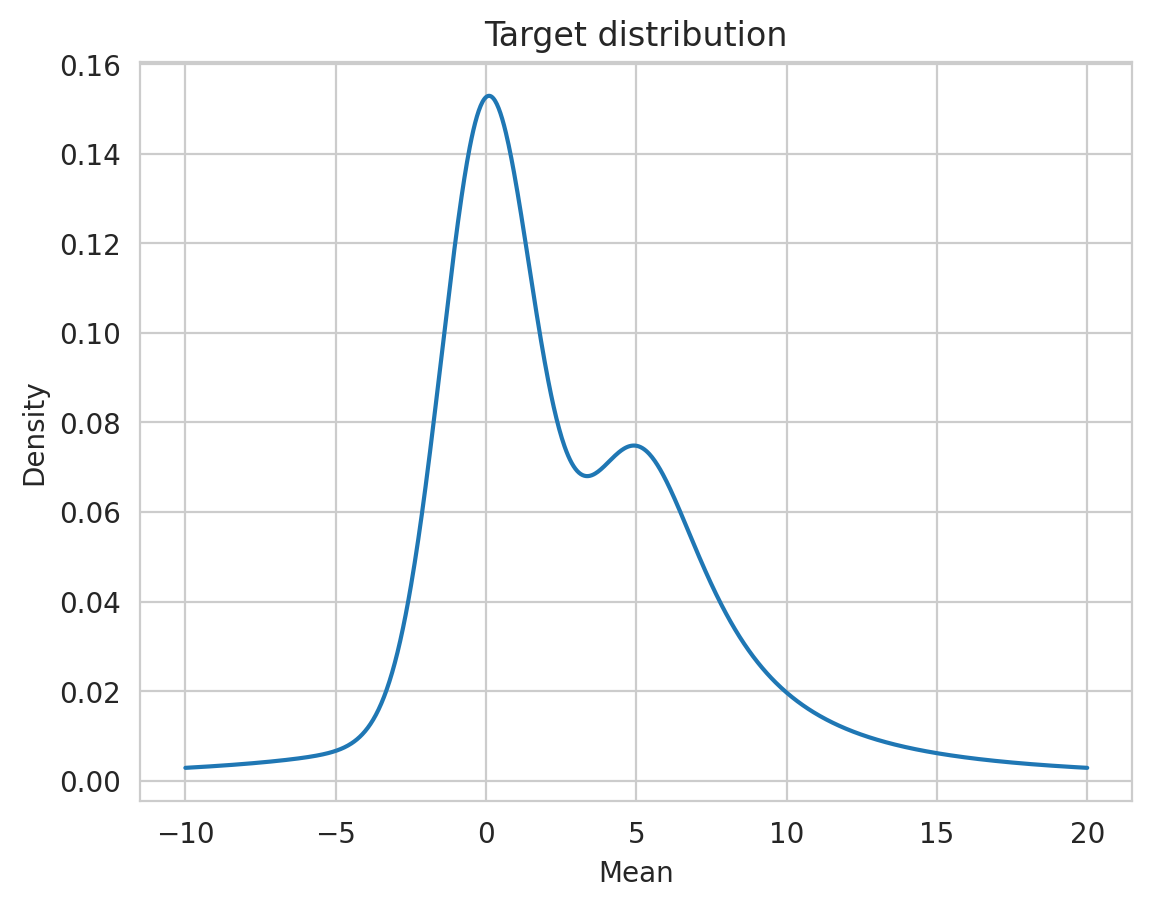

In [81]:
def target_pdf(x):
    gaussian_pdf = dist.Normal(0, 1.5).log_prob(x).exp()
    cauchy_pdf = dist.Cauchy(5, 3).log_prob(x).exp()
    return 0.5 * gaussian_pdf + 0.7 * cauchy_pdf


x_s = torch.linspace(-10, 20, 1000)
y_s = target_pdf(x_s)
plt.plot(x_s, y_s)
plt.xlabel("Mean")
plt.ylabel("Density")
plt.title("Target distribution")
plt.show()

In [82]:
def rejection_sampling(
    proposed_distribution: dist, N: int = 1000, kde_flag: bool = False
)-> None:
    '''
    Takes the proposed distributions as input and plots the estimated
    distribution using rejection sampling.

    Arguments:
    ---------

    proposed_distribution: torch.distributions
        The proposed distribution from which samples are drawn.
    N: int
        The number of samples to be drawn from the proposed distribution.
    kde_flag: bool
        If True, plots the estimated distribution using KDE plot.
        If False, plots the estimated distribution using scatter plot.

    Returns:
    --------
    None
    '''
    proposed_samples = proposed_distribution.log_prob(x_s).exp()
    M = torch.max(y_s / proposed_samples)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(x_s, y_s, label="Target distribution")
    plt.plot(x_s, M * proposed_samples, label="Scaled Proposal distribution")
    plt.plot(x_s, proposed_samples, label="Proposal distribution")

    samples_from_proposed = proposed_distribution.sample((N,))
    target_pdf_samples = target_pdf(samples_from_proposed)
    scaled_proposal_pdf = (
        M * proposed_distribution.log_prob(samples_from_proposed).exp()
    )
    uniform_samples = dist.Uniform(0, 1).sample((N,))
    accept = (uniform_samples * scaled_proposal_pdf) < target_pdf_samples
    if kde_flag:
        sns.kdeplot(
            samples_from_proposed[accept].numpy(),
            color="k",
            label="Density of accepted samples",
            lw=2,
        )
    else:
        plt.scatter(
            samples_from_proposed[accept],
            (uniform_samples * scaled_proposal_pdf)[accept],
            color="g",
            label="Accepted samples",
            alpha=0.2,
            marker=".",
            s=20,
        )
        plt.scatter(
            samples_from_proposed[~accept],
            (uniform_samples * scaled_proposal_pdf)[~accept],
            color="r",
            label="Rejected samples",
            alpha=0.2,
            marker=".",
            s=20,
        )
    plt.xlabel("Mean")
    plt.ylabel("Density")
    plt.title("Rejection sampling")
    plt.legend()

    accept_ratio = accept.sum() / N
    plt.text(
        0.17,
        0.3,
        f"Accept ratio: {accept_ratio:.2f}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
    )
    plt.show()
    print(f"Accept ratio: {accept_ratio:.2f}")

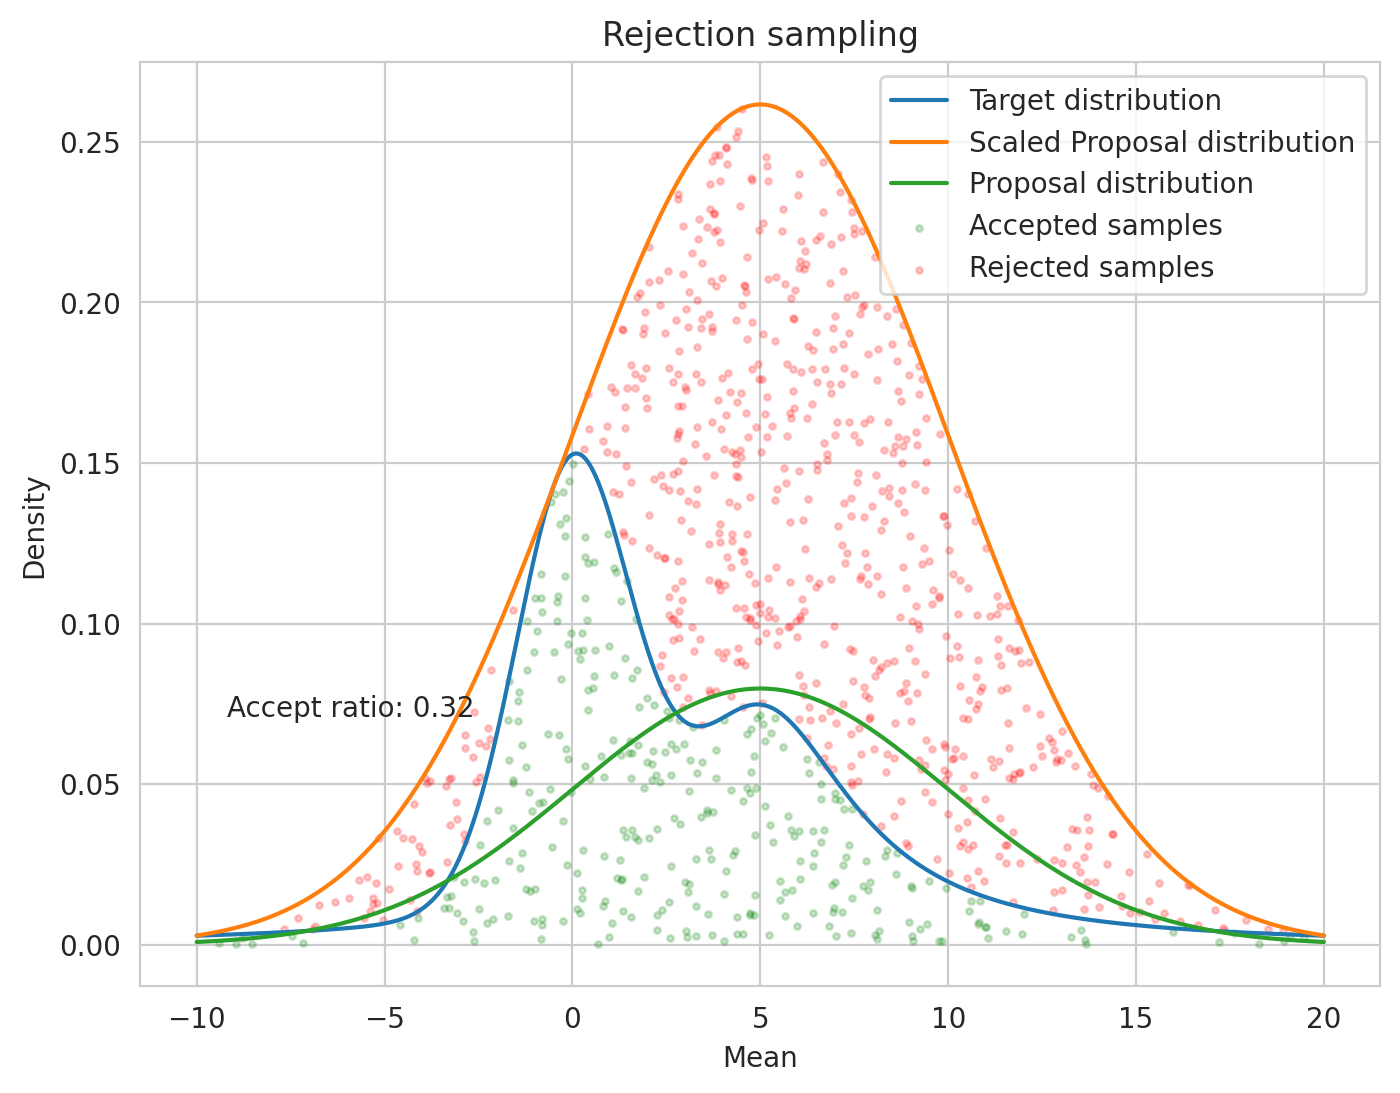

Accept ratio: 0.32


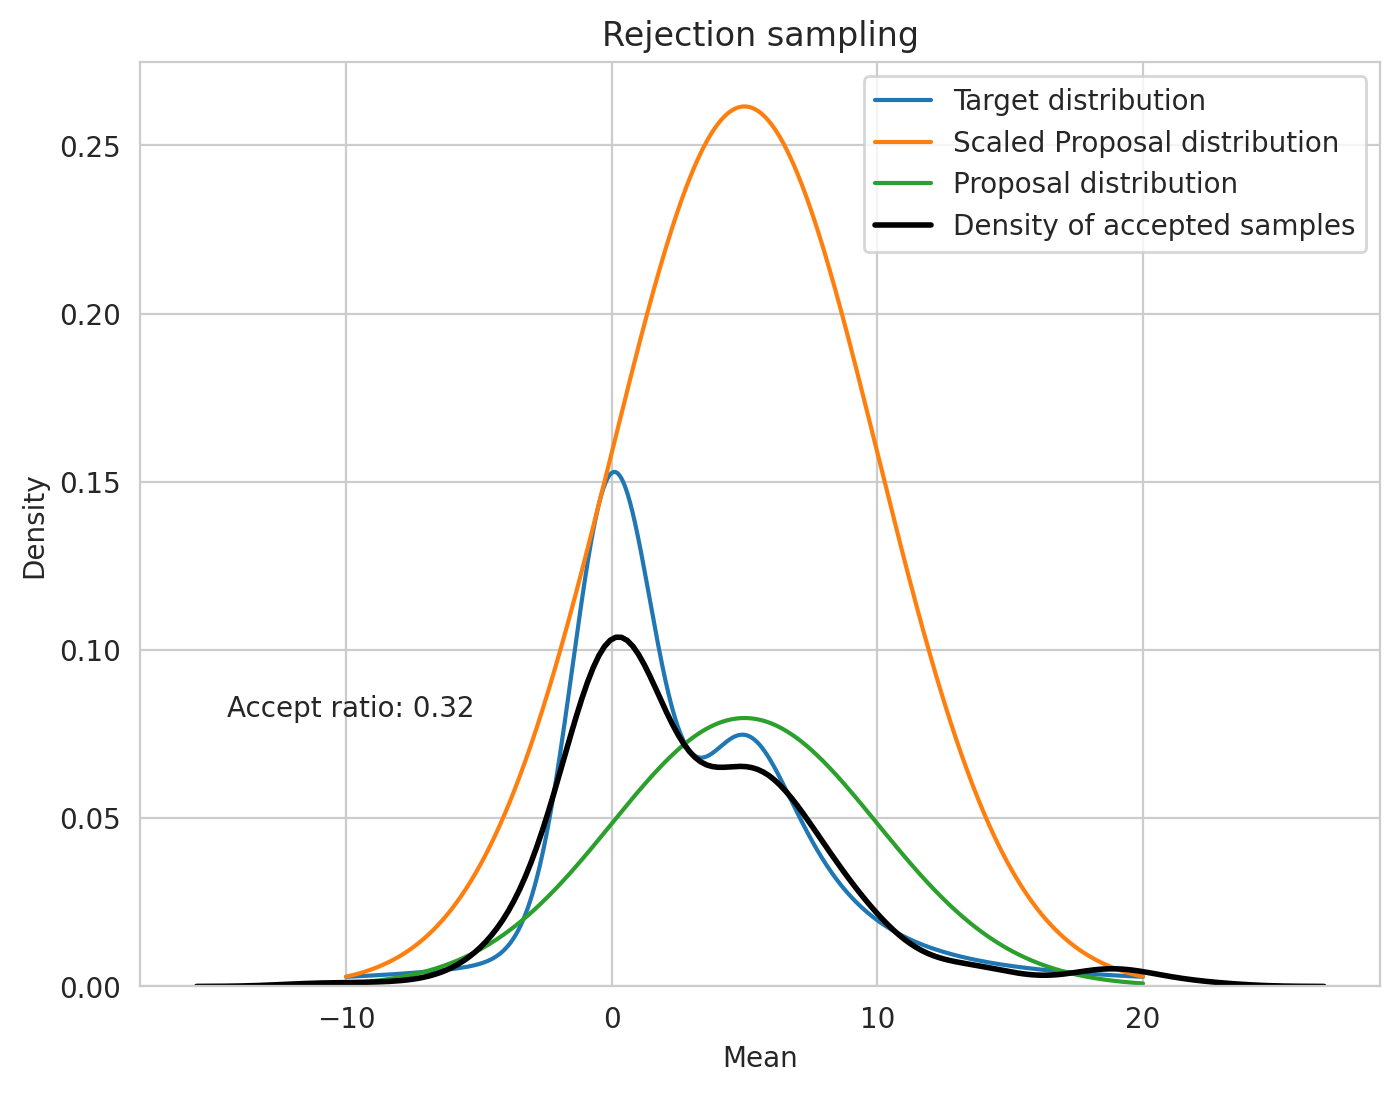

Accept ratio: 0.32


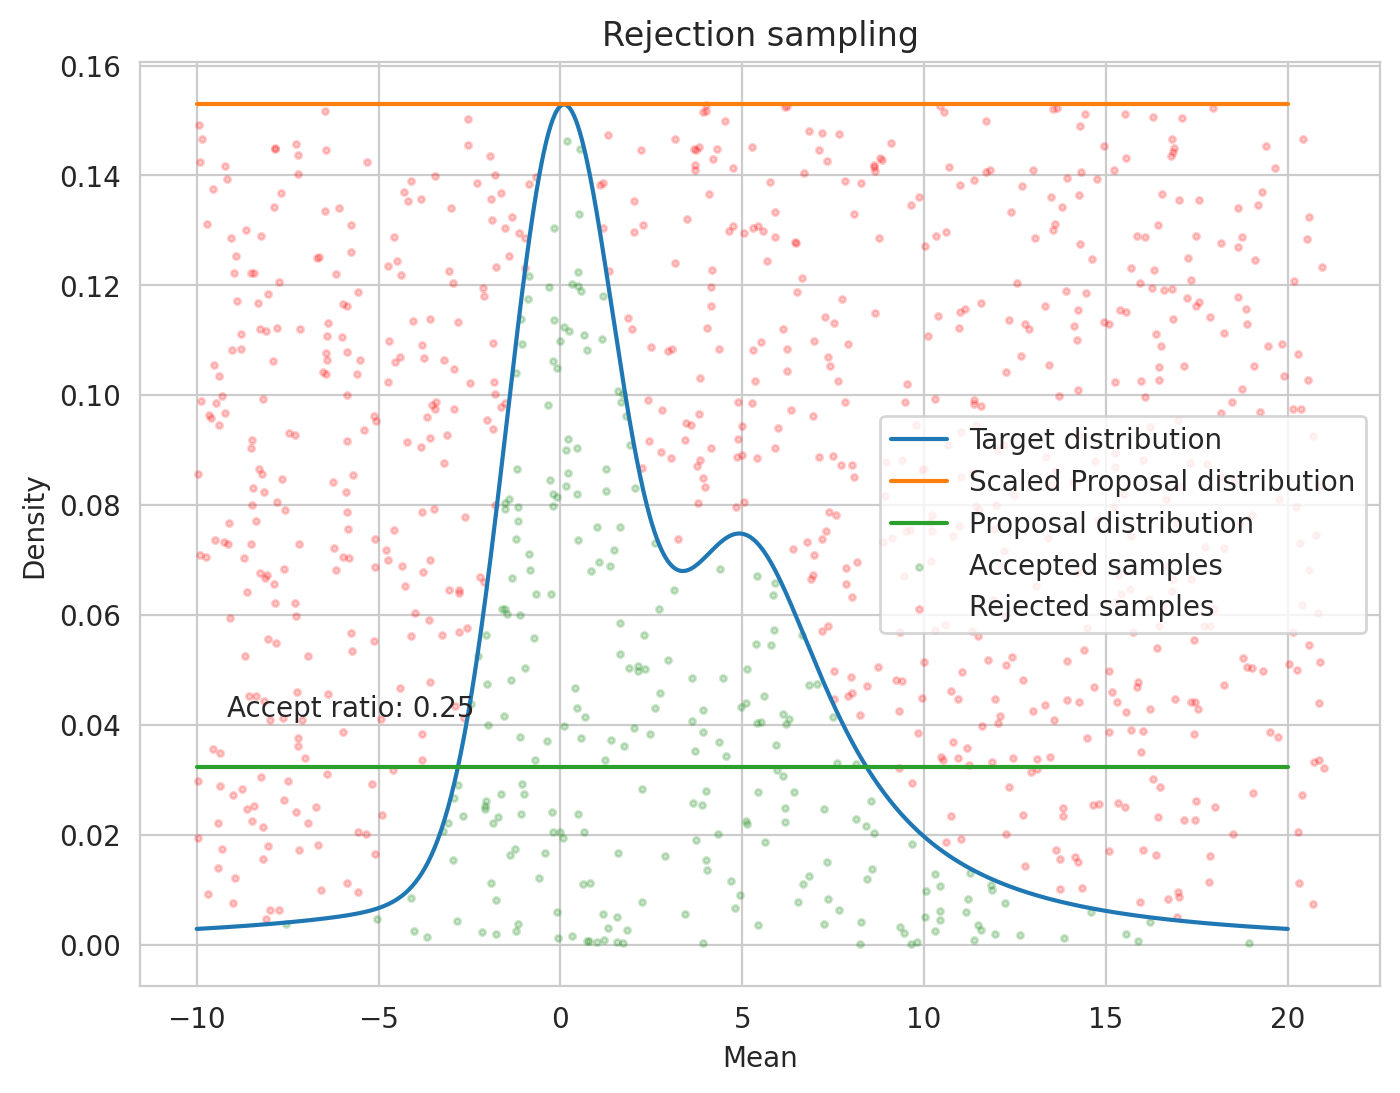

Accept ratio: 0.25


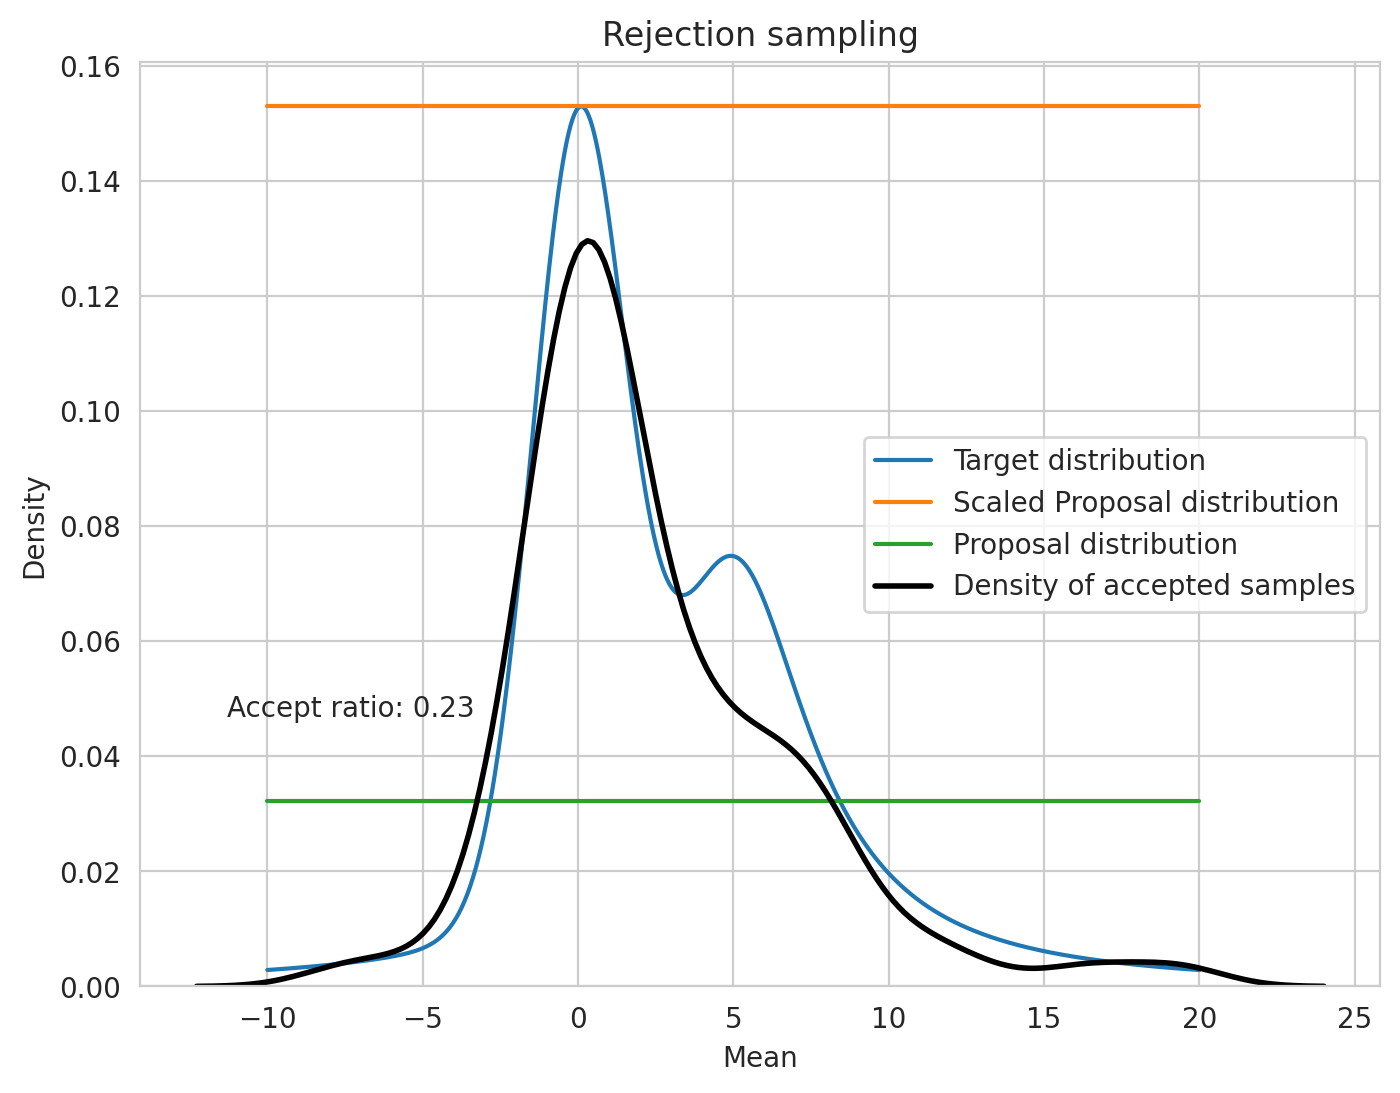

Accept ratio: 0.23


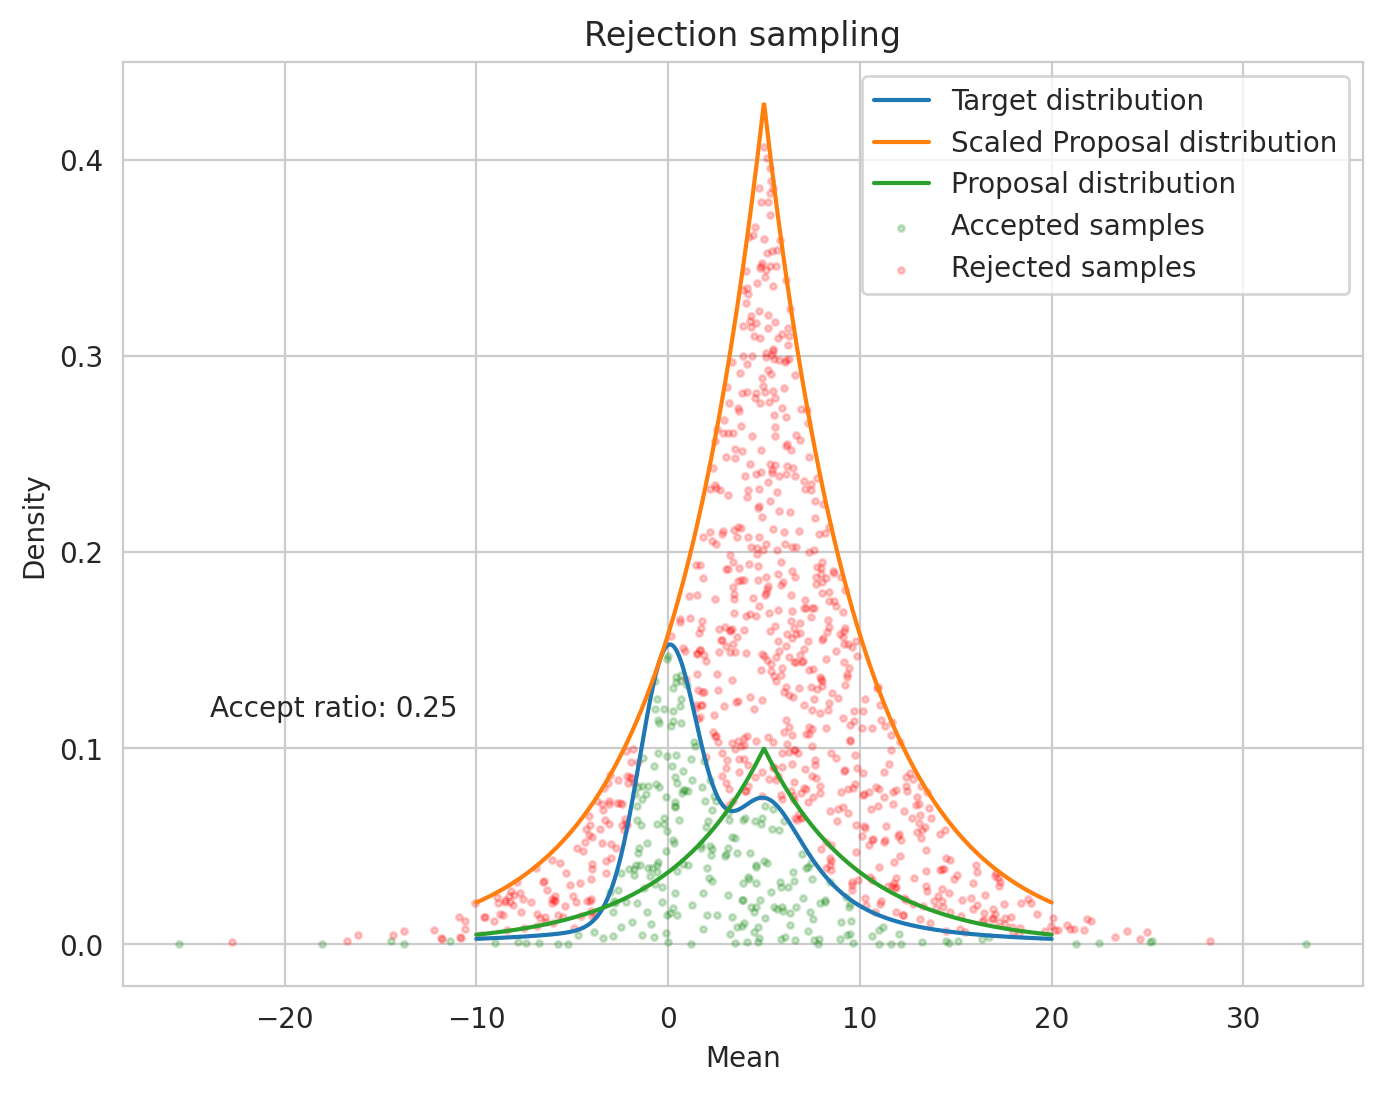

Accept ratio: 0.25


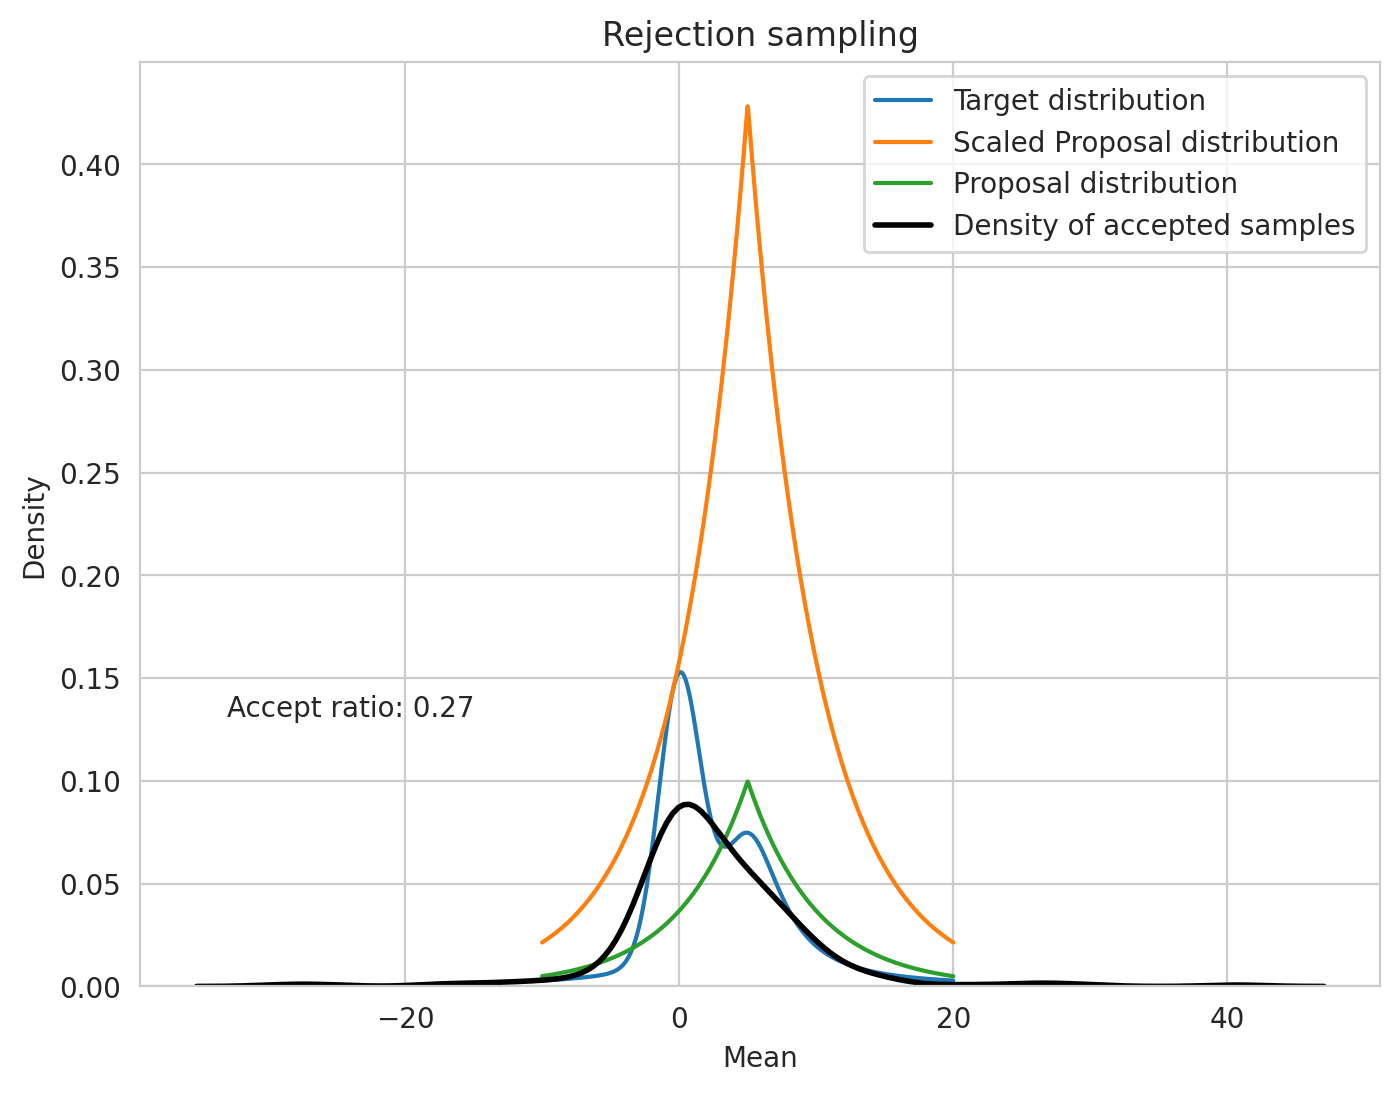

Accept ratio: 0.27


In [83]:
proposed_distributions = [
    dist.Normal(loc=5, scale=5),
    dist.Uniform(-10, 21),
    dist.Laplace(loc=5, scale=5),
]
for i in proposed_distributions:
    rejection_sampling(i, 1000, False)
    rejection_sampling(i, 1000, True)

### Question 4

In [112]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=100, noise=0.02, random_state=42)

In [113]:
torch.tensor(X).shape
import hamiltorch

In [114]:
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

In [115]:
model(torch.tensor(X, dtype=torch.float32)).shape

torch.Size([100, 1])

In [116]:
import torchsummary
torchsummary.summary(model, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              24
              ReLU-2                    [-1, 8]               0
            Linear-3                    [-1, 1]               9
Total params: 33
Trainable params: 33
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [117]:
# import jax.tree_util as jtu
def apply_prior(model):
    parameters = hamiltorch.util.flatten(model)
    log_prior = 0.0
    for param in parameters:
        log_prior += dist.Normal(loc=0, scale=1).log_prob(param).sum()
    return -log_prior


def negative_log_liklihood(model, x, y):
    logits = model(x)
    log_liklihood = dist.Bernoulli(logits=logits).log_prob(y.unsqueeze(1)).sum()
    return -log_liklihood


def log_joint(x, y):
    return apply_prior(model) + negative_log_liklihood(model, x, y)

In [118]:
XT=torch.tensor(X,dtype=torch.float32)
yT=torch.tensor(y,dtype=torch.float32)
from torch.optim import Adam

In [119]:
optimizer=Adam(model.parameters(),lr=0.01)
iterations=1000
for iter in range(iterations):
    optimizer.zero_grad()
    y_hat=model(XT)
    loss=log_joint(XT,yT).sum()
    loss.backward()
    optimizer.step()

model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1373,  0.0135],
                      [-0.4838, -1.5501],
                      [ 1.0534,  0.3812],
                      [-0.4618, -0.7399],
                      [-0.8938,  0.0428],
                      [ 1.5279, -0.1584],
                      [-0.9014,  1.6725],
                      [-0.7716, -0.4299]])),
             ('0.bias',
              tensor([ 1.3907, -0.2100, -0.0442, -0.0281, -0.1690, -0.0899, -0.1562, -0.1027])),
             ('2.weight',
              tensor([[ 1.3975, -1.6360, -1.1186, -0.8715, -0.9129, -1.5383, -1.9066, -0.8887]])),
             ('2.bias', tensor([0.9952]))])

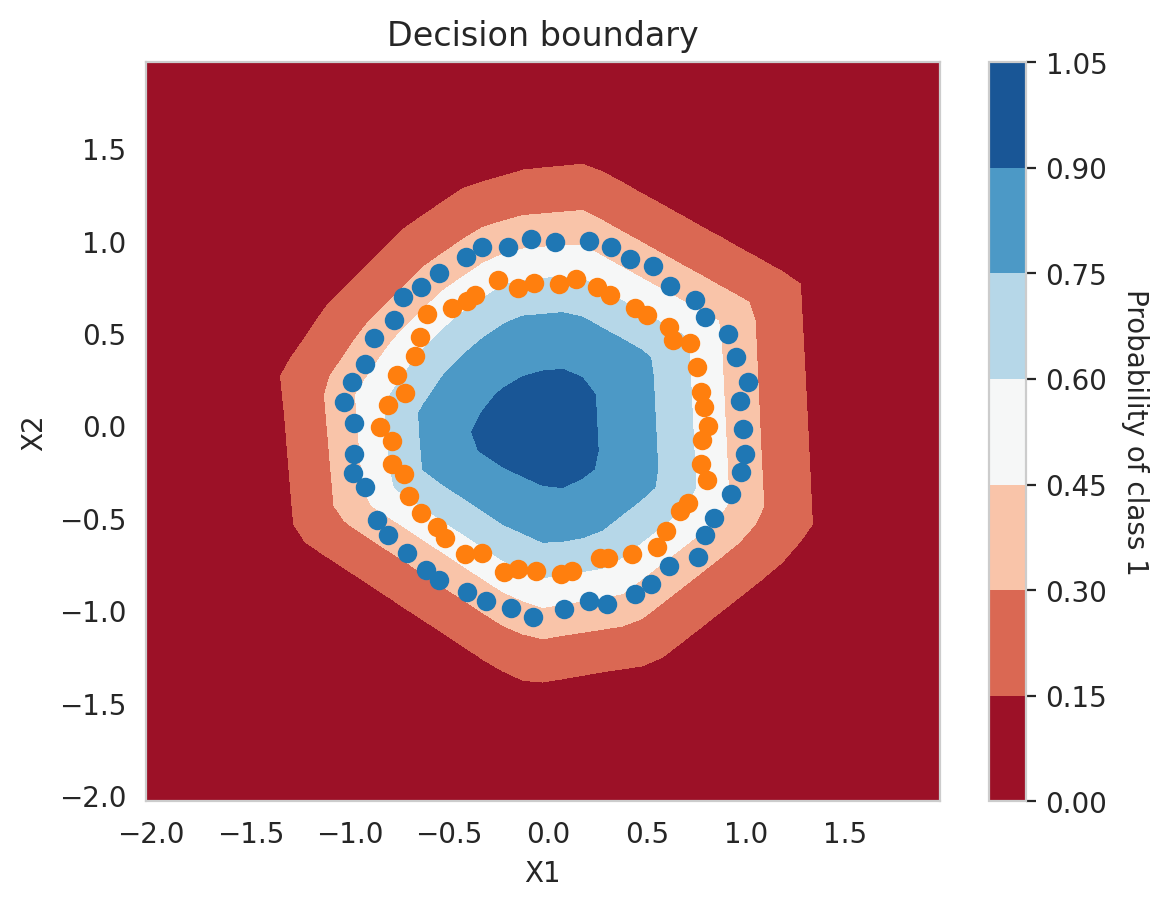

In [120]:
from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# generate dataset
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1
# define the x and y scale
x1grid = arange(min1, max1, 0.1)
x2grid = arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = hstack((r1, r2))
gridTensor = torch.tensor(grid, dtype=torch.float32)
# define the model
# make predictions for the grid
yhat = torch.sigmoid(model(gridTensor))
# keep just the probabilities for class 0

yhat = yhat.detach().numpy()
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
c = pyplot.contourf(xx, yy, zz, cmap="RdBu")
cbar = pyplot.colorbar(c)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Probability of class 1', rotation=270)
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = where(y == class_value)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.xlabel("X1")
pyplot.ylabel("X2")
pyplot.title("Decision boundary")
pyplot.show()
# Brownlee, J. (2020, August 14). Plot a Decision Surface for Machine Learning Algorithms in Python. https://machinelearningmastery.com/plot-a-decision-surface-for-machine-learning/.

### Expected size of hessian is 33x33

In [121]:
def util_compute_hessian(params,modelS,XT,yT):
    param_list=hamiltorch.util.unflatten(modelS, params)
    log_prior = dist.Normal(loc=0, scale=1).log_prob(params).sum()
    model_dicti=modelS.state_dict()
    for i,j in zip(model_dicti,param_list):
      model_dicti[i]=j
    logits=torch.func.functional_call(model, model_dicti, XT).squeeze()
    return -dist.Bernoulli(logits=logits).log_prob(yT).sum() -log_prior

In [122]:
from functools import partial
funcc=partial(util_compute_hessian,modelS=model,XT=XT,yT=yT)

In [123]:
flat_params = hamiltorch.util.flatten(model)

In [124]:
a=torch.func.hessian(funcc)
hessian=a(flat_params)

In [125]:
hessian

tensor([[ 2.0128e+01, -1.6104e-01, -9.2059e+00,  ..., -5.5078e+00,
         -4.3548e+00,  1.3799e-01],
        [-1.6104e-01,  2.0116e+01, -3.8016e-01,  ...,  1.0092e+01,
         -2.4051e+00, -1.2968e-02],
        [-9.2059e+00, -3.8016e-01,  1.1777e+01,  ...,  1.4476e+00,
          3.9579e+00,  3.0346e+00],
        ...,
        [-5.5078e+00,  1.0092e+01,  1.4476e+00,  ...,  1.4882e+01,
          1.5879e+00,  1.1190e+01],
        [-4.3548e+00, -2.4051e+00,  3.9579e+00,  ...,  1.5879e+00,
          3.6512e+00,  4.8013e+00],
        [ 1.3799e-01, -1.2968e-02,  3.0346e+00,  ...,  1.1190e+01,
          4.8013e+00,  2.4924e+01]], grad_fn=<ViewBackward0>)

In [126]:
with torch.no_grad():
  covariance=torch.inverse(hessian)

<Axes: >

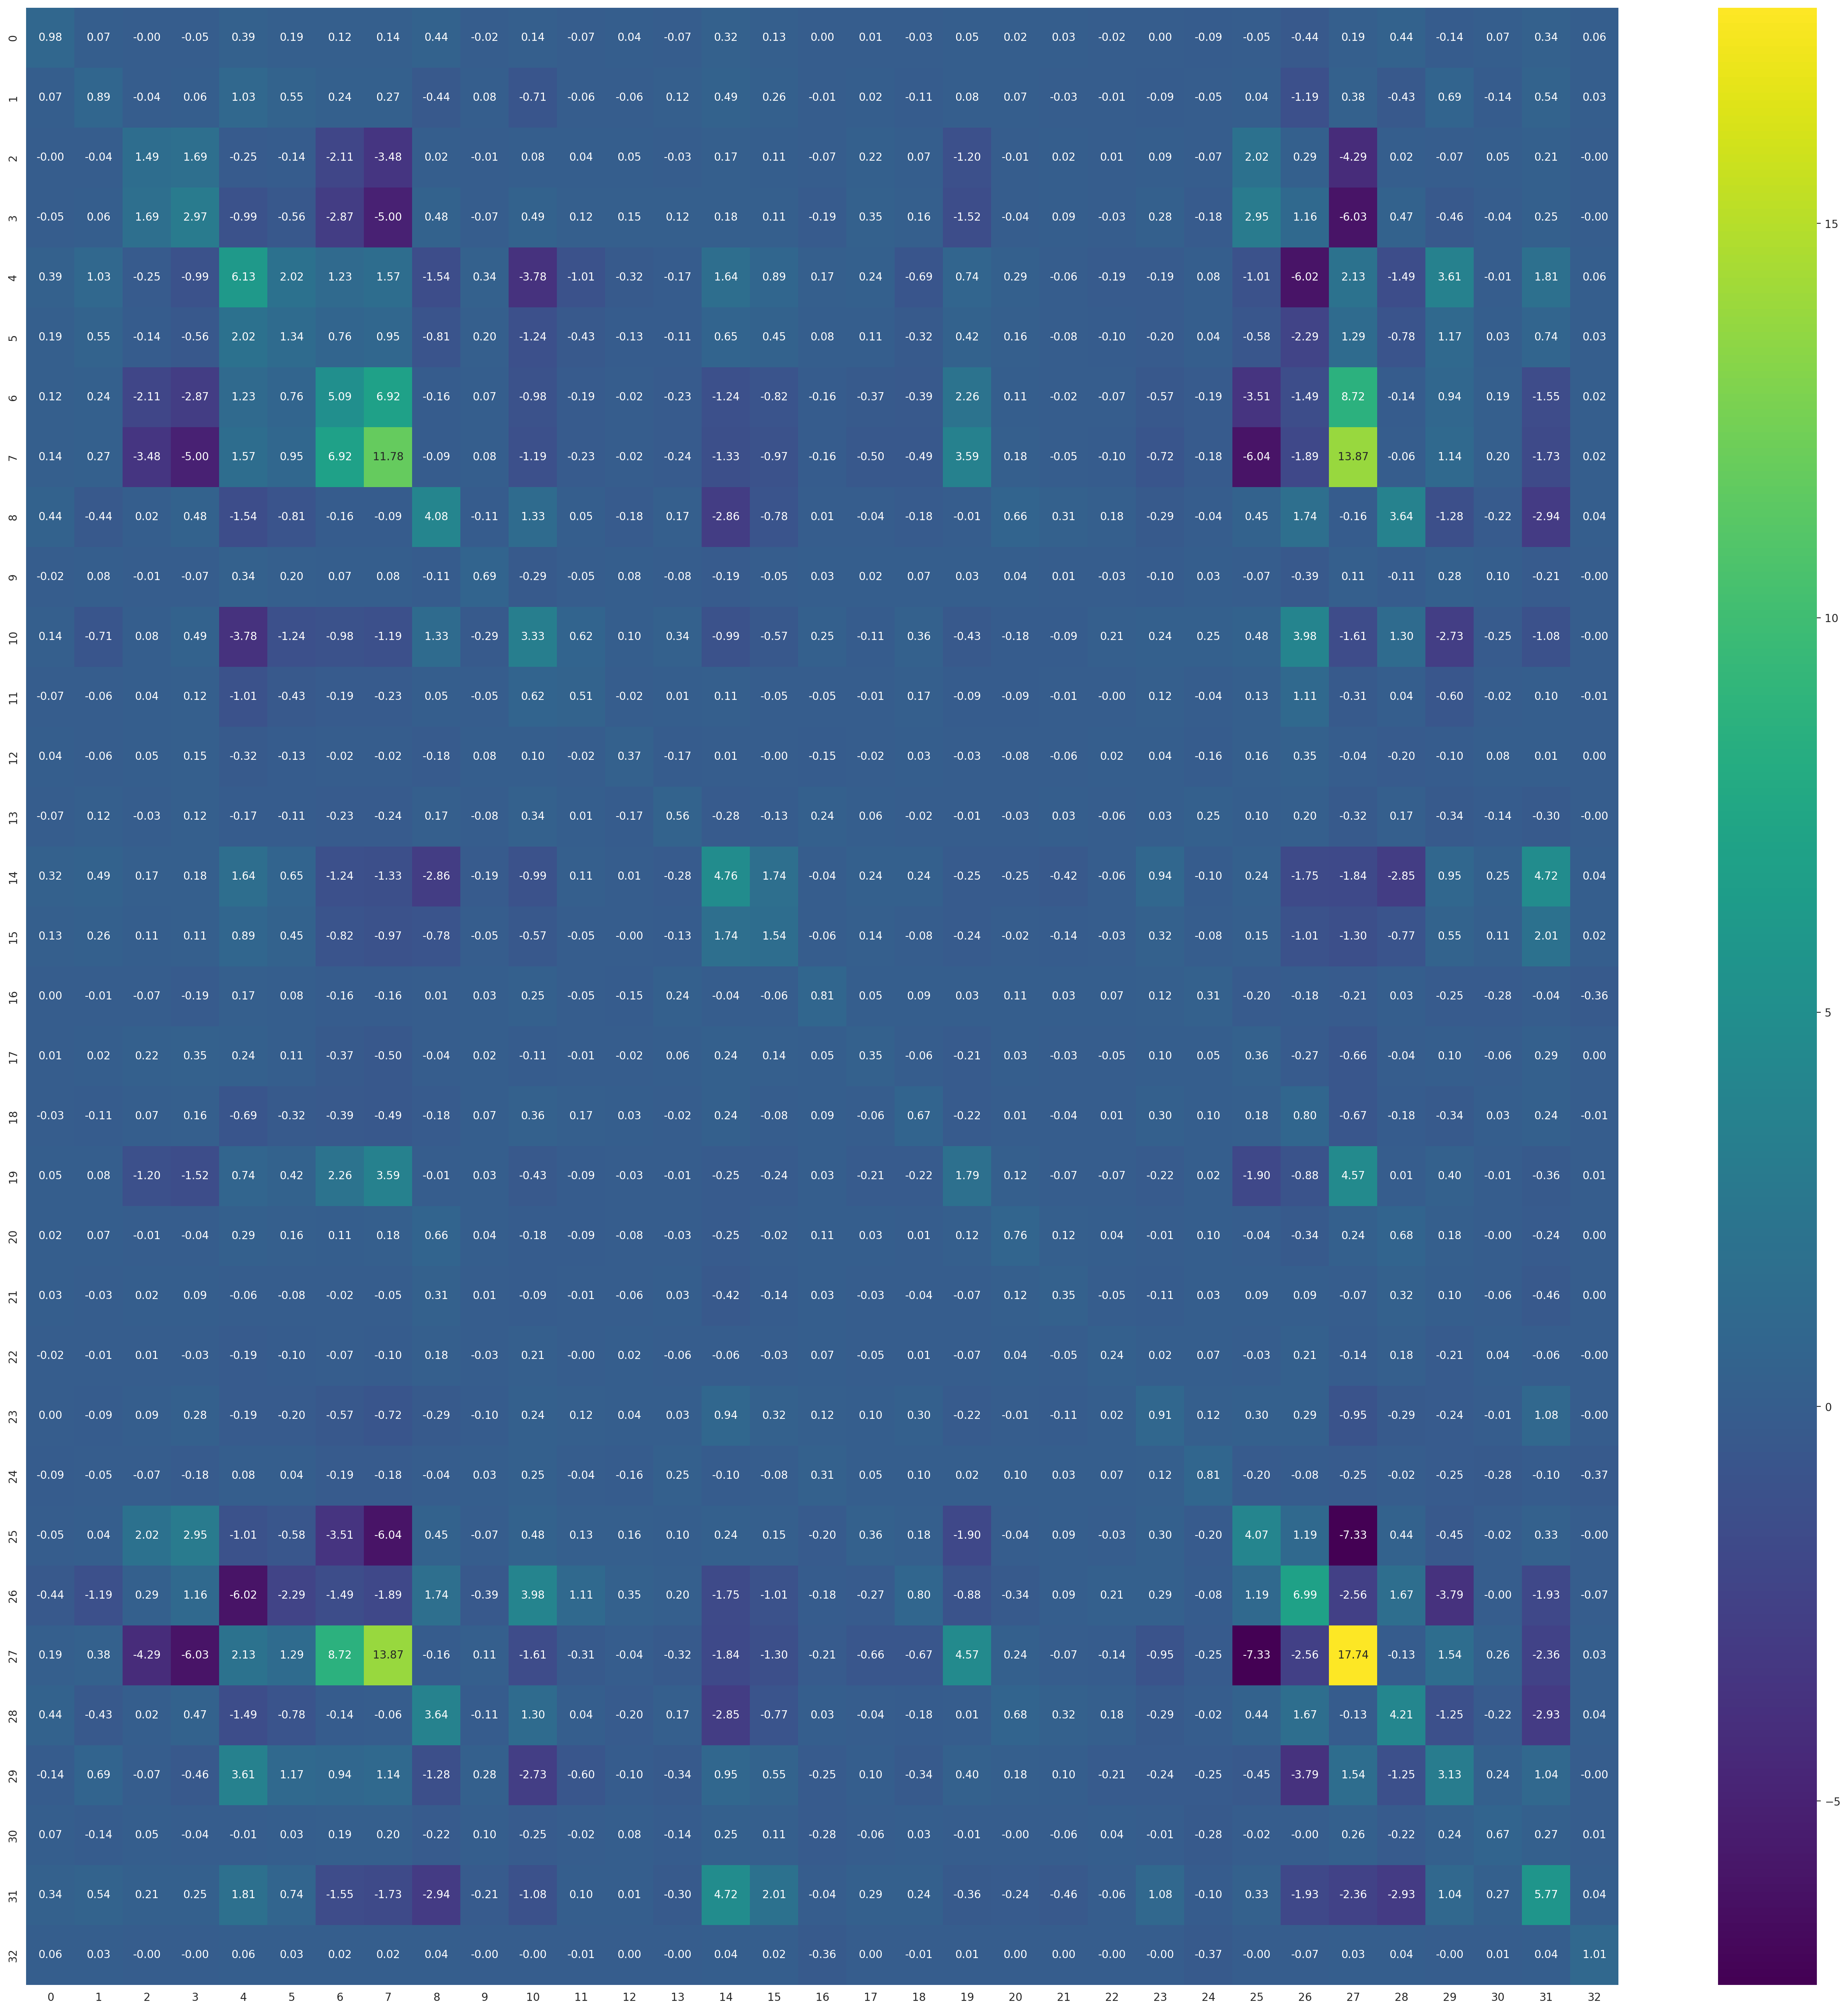

In [127]:
plt.figure(figsize=(33, 33))
sns.heatmap(covariance.detach().numpy(), annot=True, fmt=".2f", cmap="viridis")

In [128]:
np.linalg.eigvals(covariance.detach().numpy())>0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [129]:
diagonal_hessian=torch.diag(torch.diag(hessian))
diagonal_covariance=torch.inverse(diagonal_hessian)

### Inverting a diagnal matrix is easy because

1. the inverse of a diagonal matrix is also a diagonal matrix
2. the inverse of a diagonal matrix is the reciprocal of the diagonal elements



<Axes: >

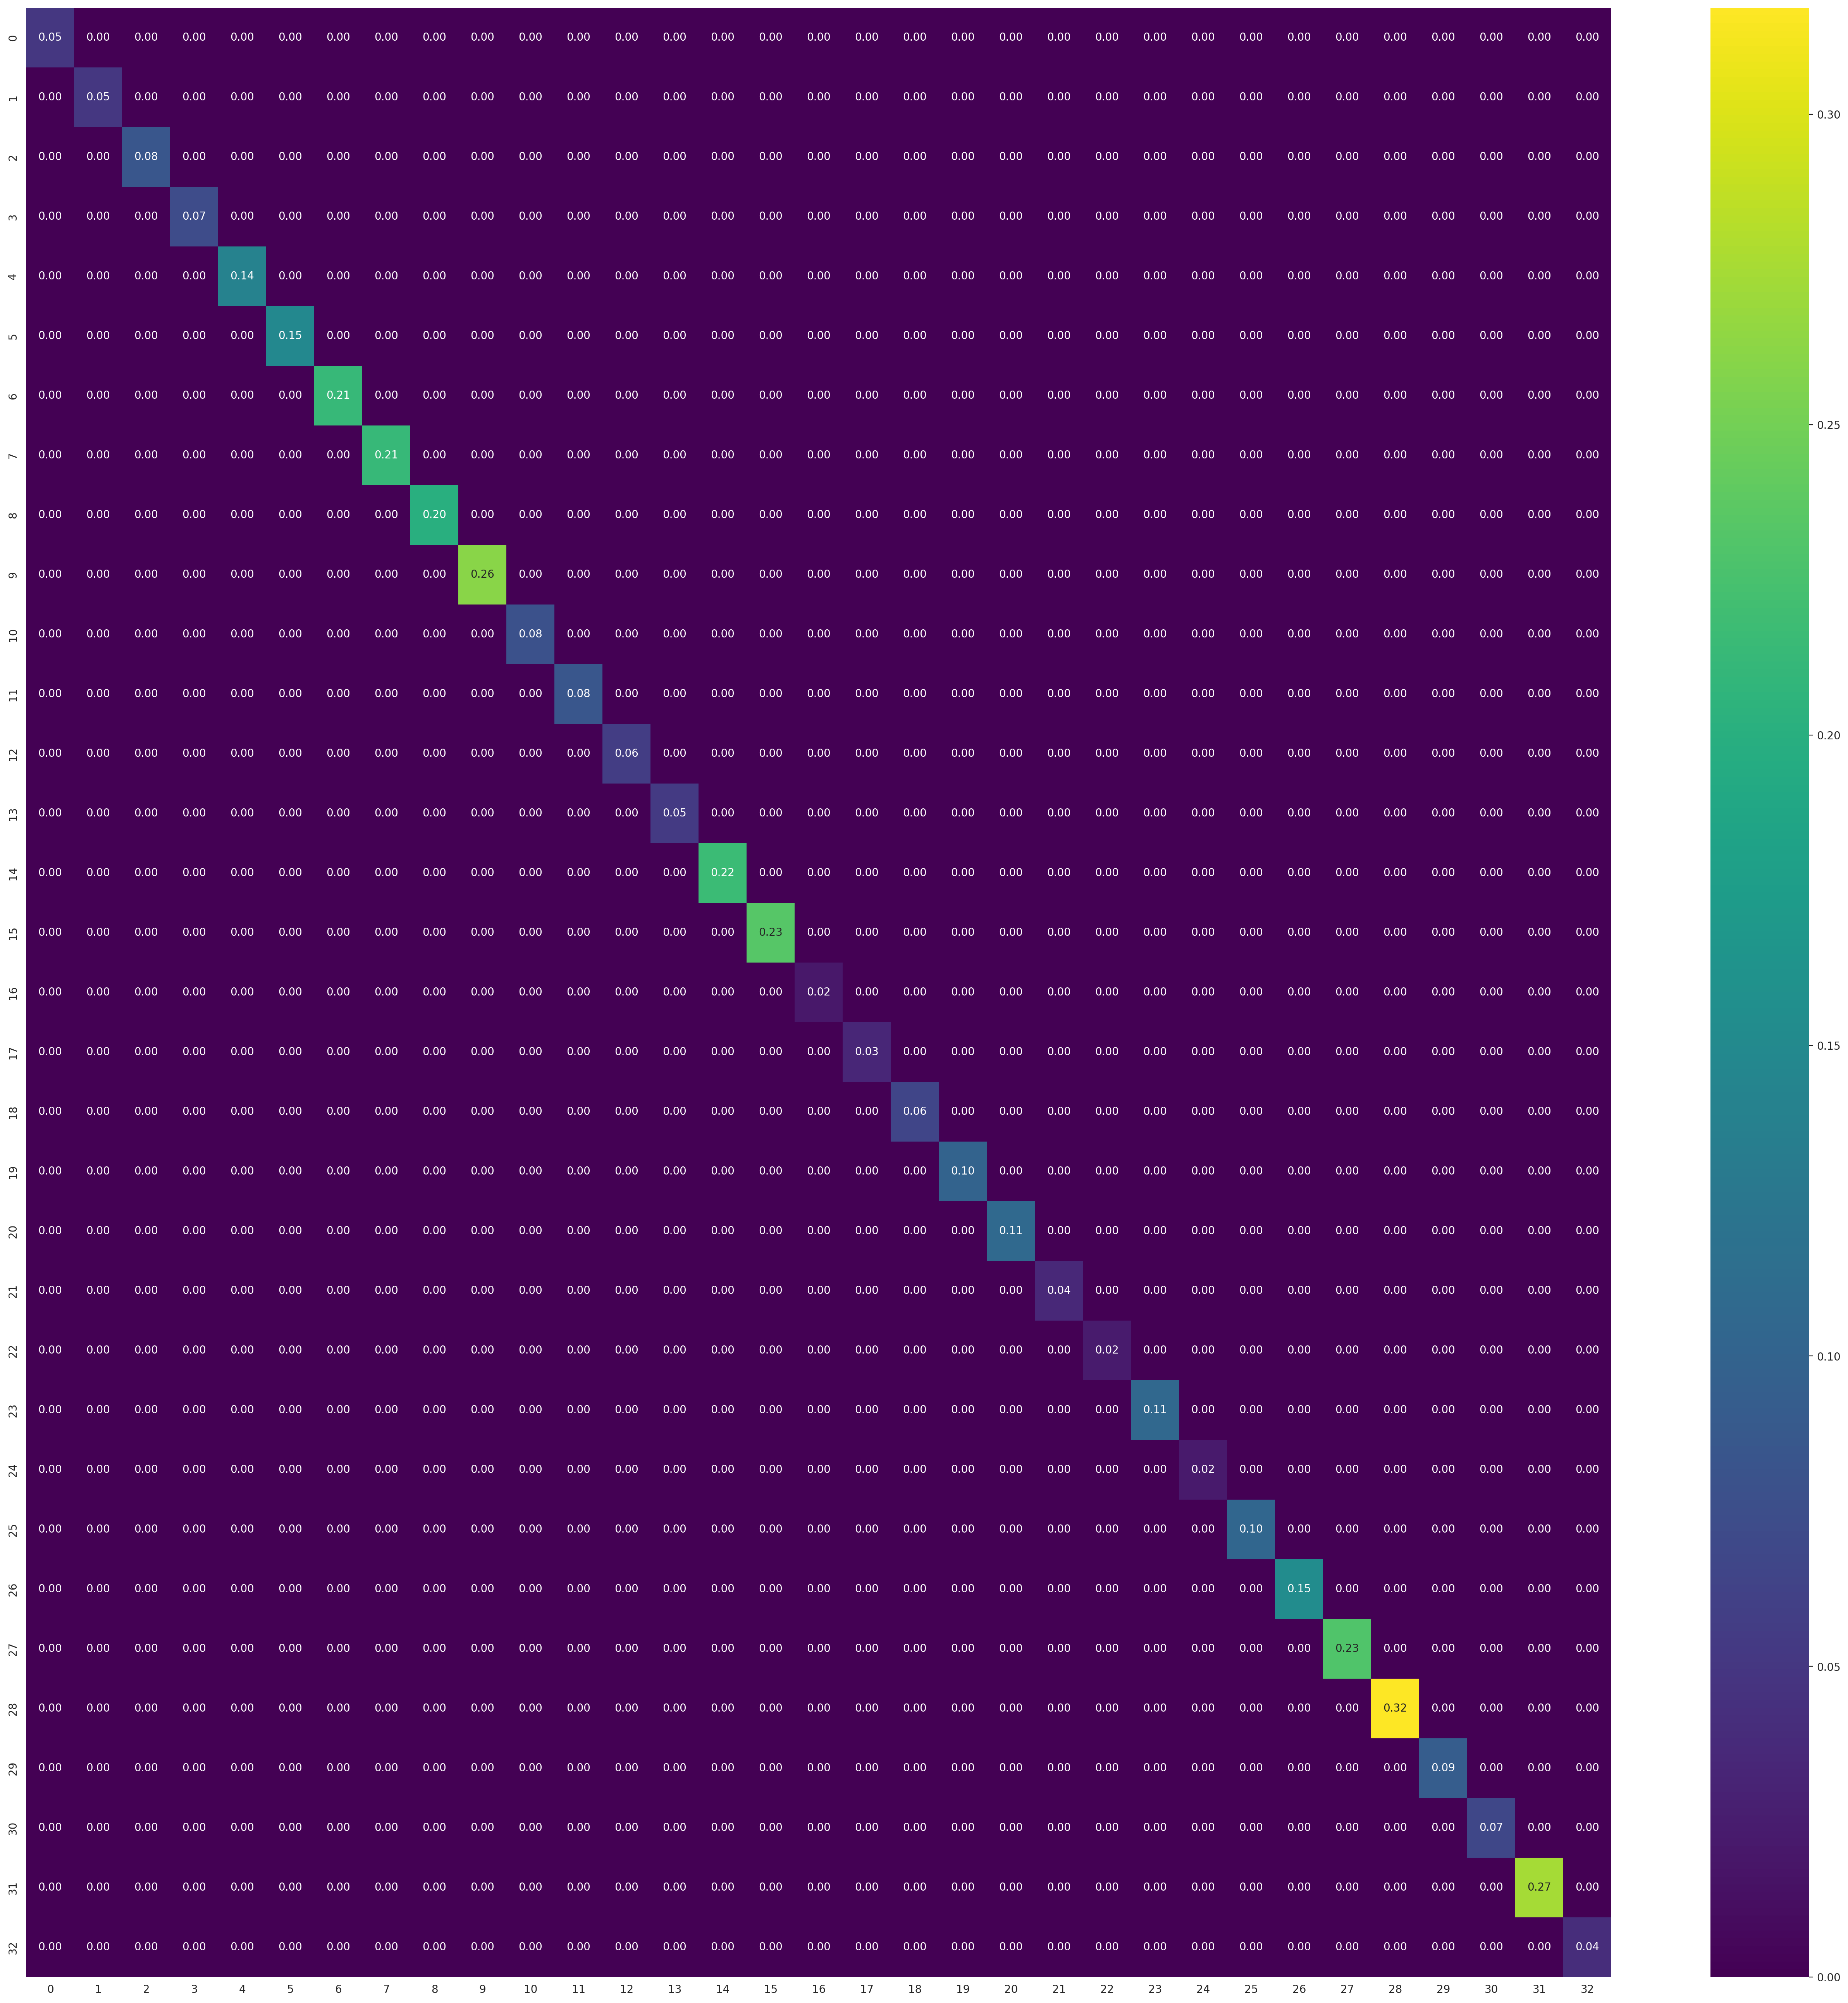

In [130]:
plt.figure(figsize=(33, 33))
sns.heatmap(diagonal_covariance.detach().numpy(), annot=True, fmt=".2f", cmap="viridis")

In [131]:
laplace_posterior=dist.MultivariateNormal(flat_params, diagonal_covariance
                                          )
samples=laplace_posterior.sample((1000,))


In [132]:
samples.shape

torch.Size([1000, 33])

In [133]:
def forward_pass(params,X):
    unflattened=hamiltorch.util.unflatten(model, params)
    hamiltorch.util.update_model_params_in_place(model, unflattened)
    return torch.sigmoid(model(X))
def mean_val(params,X):
    l=[]
    for i in params:
        l.append(forward_pass(i,X))
    return torch.stack(l).mean(dim=0),torch.stack(l).std(dim=0)

In [134]:
mean,std=mean_val(samples,gridTensor)

In [135]:
gridTensor.shape

torch.Size([1681, 2])

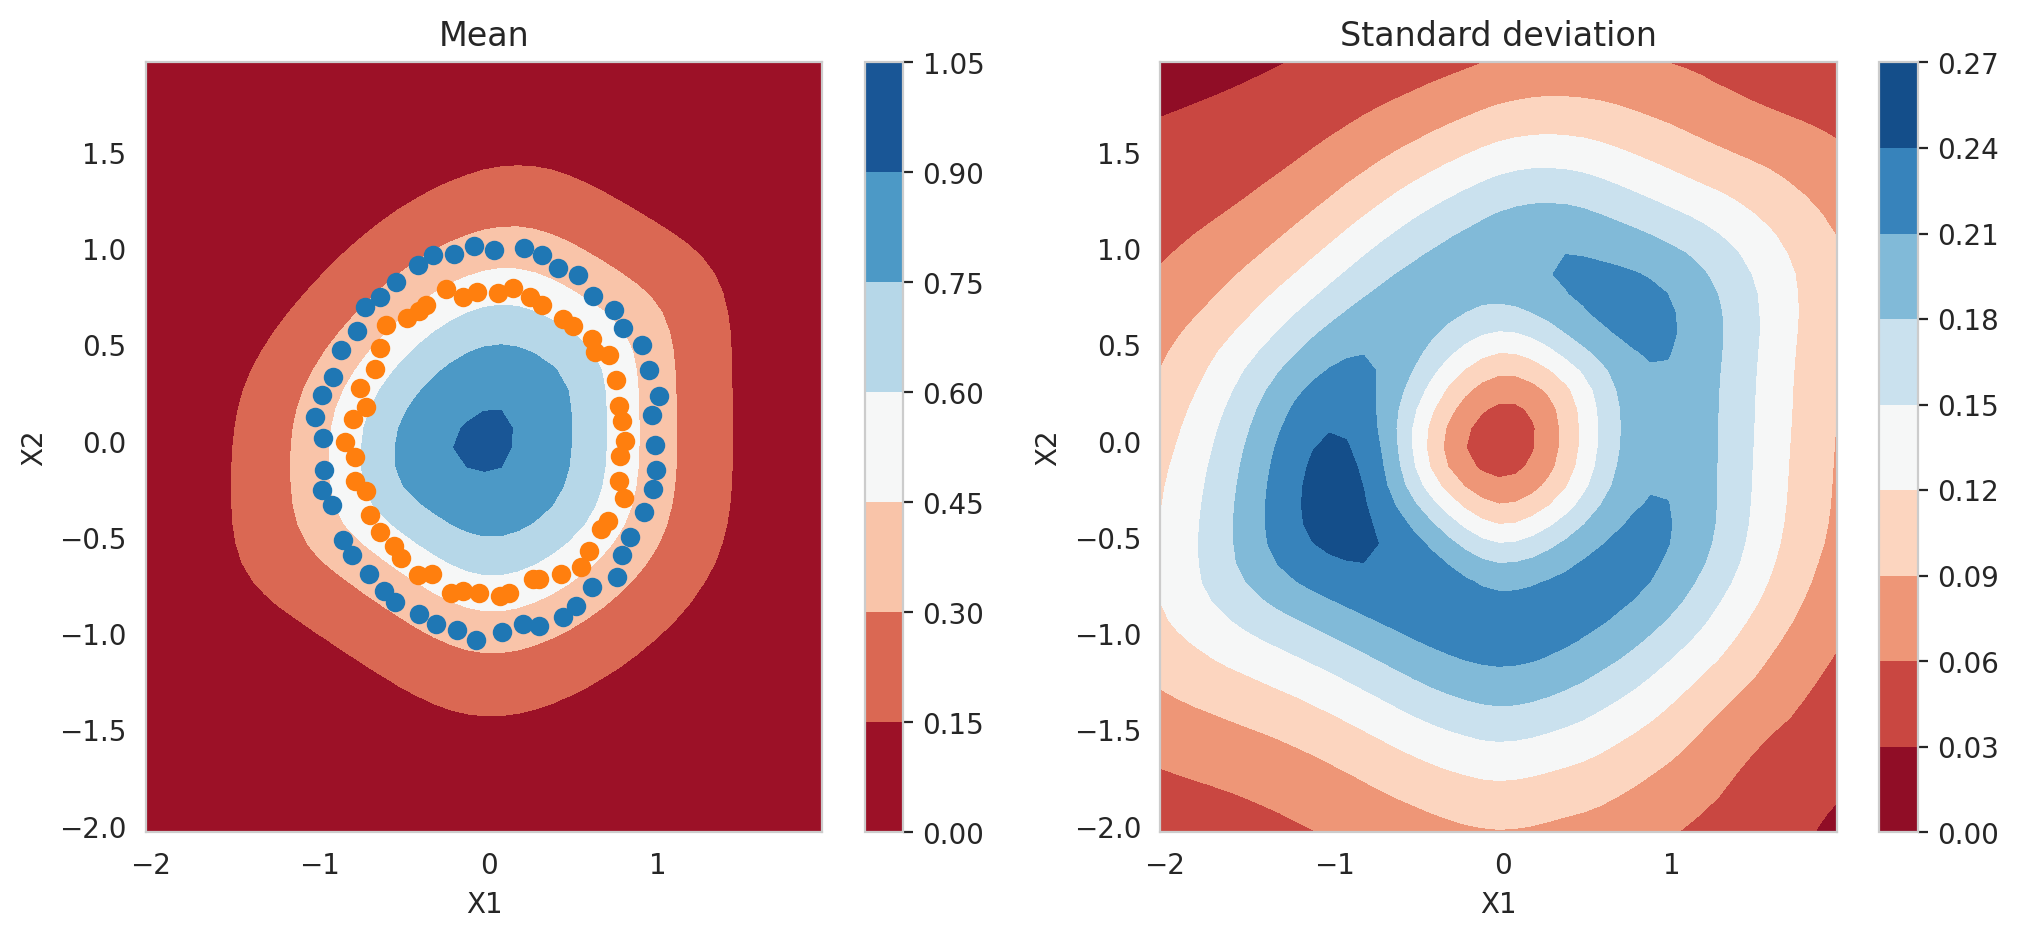

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
yhat_mean = mean.detach().numpy()
zz_mean = yhat_mean.reshape(xx.shape)
c1 = ax1.contourf(xx, yy, zz_mean,cmap="RdBu")
# add a legend, called a color bar
zz_std=std.detach().numpy().reshape(xx.shape)
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = where(y == class_value)
    # create scatter of these samples
    ax1.scatter(X[row_ix, 0], X[row_ix, 1])
    # ax2.scatter(X[row_ix, 0], X[row_ix, 1])
c2=ax2.contourf(xx,yy,zz_std,cmap="RdBu")
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)
#label the axis of ax1 and ax2
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax1.set_title("Mean")
ax2.set_title("Standard deviation")
plt.show()

### Observations
The mean classifyies the data correctly, the standard deviations is high in between the boundary of the data this suggests that the model is uncertain at the boundary where the probability of the data is near 0.5.